# Banknote authentication
Aim is to develop and evaluate a reliable model for banknote authentication that can accurately distinguish between genuine and counterfeit notes.
<br> This script tests the VGG16 model.

In [ ]:
# ensure access to mydrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import libraries
import os
import random
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualkeras
from IPython.display import Image, display
import visualkeras

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# define directory where the dataset is stored
dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/banknotes'

In [ ]:
# define the image size and channels
img_size = (224, 224)
img_channels = 3


In [3]:
# calculate number of notes in the dataset
num_notes = len(os.listdir(os.path.join(dataset_dir, 'real_notes'))) + len(os.listdir(os.path.join(dataset_dir, 'fake_notes')))
print('nr of real notes:', len(os.listdir(os.path.join(dataset_dir, 'real_notes'))))
print('nr of fake notes:', len(os.listdir(os.path.join(dataset_dir, 'fake_notes'))))
print('total nr of notes:', num_notes)

In [ ]:
# extract features for each image in the dataset.
def extract_features(dataset_dir, model):
  '''Inputs:
  directory where dataset is
  model used
  '''
  features_list = []
  labels_list = []
  note_paths_list = []

  for class_dir in os.listdir(dataset_dir):
      if class_dir.startswith('.'):
          continue
      class_path = os.path.join(dataset_dir, class_dir)

      for note_dir in os.listdir(class_path):
          if note_dir.startswith('.'):
              continue
          note_path = os.path.join(class_path, note_dir)

          num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])
          images = []

          for i in range(1, num_images_per_note + 1):
              image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')

              image = cv2.imread(image_path)
              image = cv2.resize(image, img_size)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # VGG16 model expects RGB
              image = preprocess_input(image)
              images.append(image)

          features = model.predict(np.array(images))
          features = features.reshape((1, num_images_per_note,  7, 7, 512)) # 1 batch, 6 images, 7x7 grid of features, 512 channels/features per grid

          features_list.append(features)
          if class_dir == 'real_notes':
              labels_list.append(0)
          else:
              labels_list.append(1)

          note_paths_list.append(note_path)

  X = np.vstack(features_list)
  y = np.array(labels_list)

  return X, y, note_paths_list

In [ ]:
# define VGG16 model with pre-trained weights
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], img_channels))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


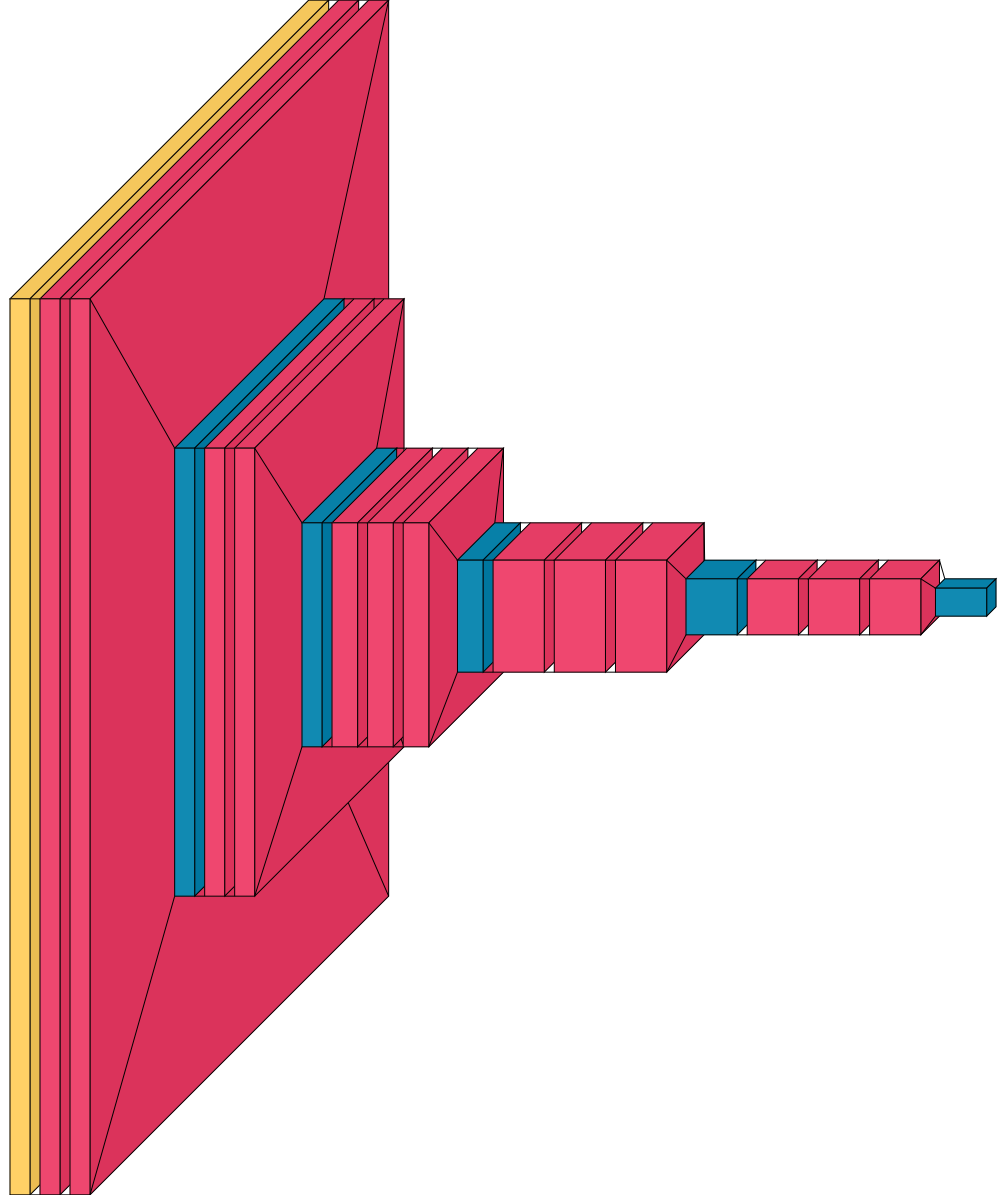

In [ ]:
file_path = '/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models/'
image_path = os.path.join(file_path, 'vgg16.png')
visualkeras.layered_view(vgg16_model, to_file=image_path)
display(Image(filename=image_path))

In [ ]:
# # comment if done
# save feature extraction 
# X, y, note_paths = extract_features(dataset_dir, vgg16_model)

# np.save('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/vgg16/X.npy', X)
# np.save('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/vgg16/y.npy', y)
# np.save('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/vgg16/note_paths.npy', note_paths)

In [ ]:
# load extracted features
X = np.load('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/vgg16/X.npy')
y = np.load('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/vgg16/y.npy')
note_paths = np.load('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/vgg16/note_paths.npy')

In [4]:
# split train test set
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(X, y, note_paths, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=seed)


In [ ]:
input_tensor = Input(shape=(X.shape[1],  7, 7, 512))

# Calculate the output shape of the Lambda layer
def lambda_output_shape(input_shape):
    return [(input_shape[0],) + input_shape[2:]] * input_shape[1]

# Wrap the lambda function in a regular function
def unstack_tensor(x):
    return tf.compat.v1.unstack(x, axis=1)

# split_tensors = Lambda(lambda x: tf.unstack(x, axis=1))(input_tensor)
split_tensors = Lambda(unstack_tensor, output_shape=lambda_output_shape)(input_tensor)

branches = [Flatten()(split_tensors[i]) for i in range(X.shape[1])]
concat = Concatenate()(branches)
dropout = Dropout(0.6)(concat)
fcnn = Dense(64, activation='relu', kernel_regularizer=l2(0.00005))(dropout)  # L2 regularization
fcnn = Dense(1, activation='sigmoid')(fcnn)
model = Model(inputs=input_tensor, outputs=fcnn)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# directory to save best Model
best_model_dir = '/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models'

In [ ]:
# define the ModelCheckpoint callback with model
best_model_file_path = os.path.join(best_model_dir, 'vgg16_model.keras')
checkpoint = ModelCheckpoint(best_model_file_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8409 - loss: 9.8567 
Epoch 1: val_loss improved from inf to 2.55587, saving model to /content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models/vgg16_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step - accuracy: 0.8439 - loss: 9.8030 - val_accuracy: 0.9856 - val_loss: 2.5559
Epoch 2/20
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9851 - loss: 3.8409
Epoch 2: val_loss improved from 2.55587 to 1.45195, saving model to /content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models/vgg16_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9850 - loss: 3.6024 - val_accuracy: 0.9892 - val_loss: 1.4520
Epoch 3/20
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9879 - loss: 0.6831
Epoch 3: val_loss improved from 1.45195 to 1.07550, saving model to /content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models/vgg16_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accu

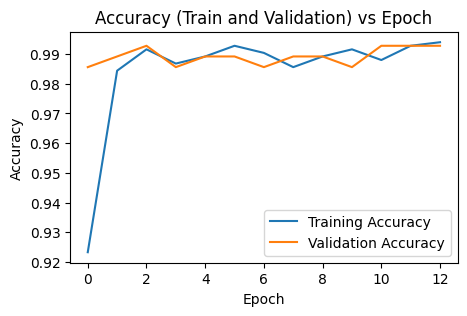

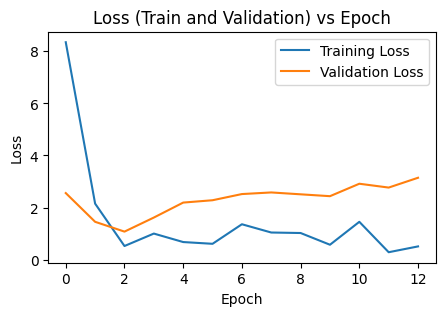

In [ ]:
# plot the training and validation accuracy vs epoch
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (Train and Validation) vs Epoch')
plt.legend(loc='lower right')
plt.show()

# plot the training and validation loss vs epoch
fig, ax = plt.subplots(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Train and Validation) vs Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# # load best model saved by ModelCheckpoint
# best_model = tf.keras.models.load_model(best_model_file_path)

# load best model saved by ModelCheckpoint
best_model = load_model(best_model_file_path,
                       custom_objects={'unstack_tensor': unstack_tensor,
                                       'lambda_output_shape': lambda_output_shape},
                       safe_mode=False)

test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9858 - loss: 3.3287
Test loss: 2.188830852508545
Test accuracy: 0.9856114983558655


In [ ]:
# model evaluation on the validation set
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9973 - loss: 0.3690
Validation loss: 1.0754960775375366
Validation accuracy: 0.9928057789802551


In [ ]:
# make predictions using the best model on test set
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


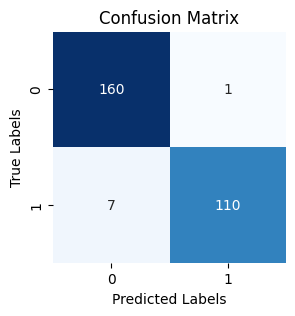

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, ax=ax , fmt='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [ ]:
# determine precision, recall, and F1 score
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Precision: 0.99
Recall: 0.94
F1 score: 0.96


In [ ]:
# model prediction
y_pred_probs = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


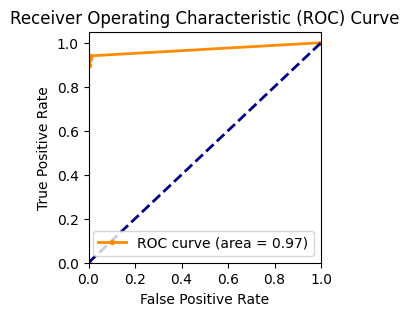

In [ ]:
# calculate the FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, marker='o', markersize=3 , label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

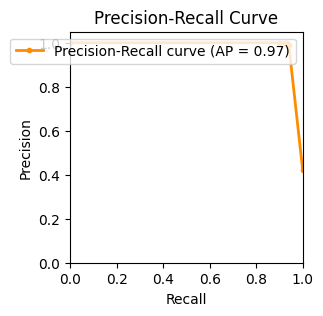

In [ ]:
# calculate precision, recall, and threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# calculate the average precision
average_precision = average_precision_score(y_test, y_pred_probs)

# plot Precision-Recall curve
plt.figure(figsize=(3, 3))
plt.plot(recall, precision, color='darkorange', lw=2,marker='o', markersize=3, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()